<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/231121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
# 비전딥러닝 관련 : https://wikidocs.net/135874

In [ ]:
# Dataset - https://www.kaggle.com/datasets/daggysheep/find-a-car-park
# Dataset2 - https://www.kaggle.com/datasets/phylake1337/fire-dataset
os.environ['KAGGLE_USERNAME'] = 'leelang' # username
os.environ['KAGGLE_KEY'] = 'bc31229ab73924283c71cf48fff880a0' # key
!kaggle datasets download -d daggysheep/find-a-car-park

Dataset URL: https://www.kaggle.com/datasets/daggysheep/find-a-car-park
License(s): CC-BY-NC-SA-4.0
100% 4.99G/5.00G [01:03<00:00, 100MB/s]
100% 5.00G/5.00G [01:03<00:00, 85.1MB/s]


In [ ]:
!unzip -q find-a-car-park.zip

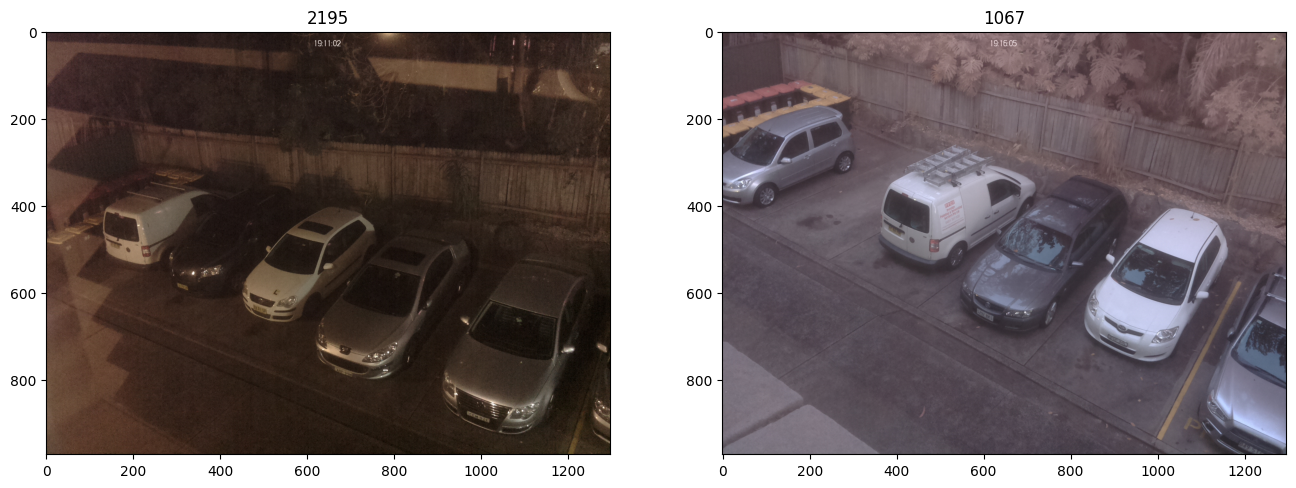

In [ ]:
# Preview Dataset
BASE_PATH = 'data'

full_list = glob.glob(os.path.join(BASE_PATH, 'Full/*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, 'Free/*.jpg'))

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(full_list))
plt.imshow(full_img)
plt.subplot(1, 2, 2)
plt.title(len(free_list))
plt.imshow(free_img)

In [ ]:
# DataGenerator
# 어그멘테이션
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['Full', 'Free'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
{'Full': 0, 'Free': 1}


In [ ]:
# Load Model for Transfer Learning
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False) #1000이미지 분류 모델

x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 피기
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Switch Layers to be Trainable # 레이어 웨이트 변경 방지
for layer in model.layers:
    layer.trainable = True

In [ ]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.keras', monitor='val_acc', save_best_only=True, verbose=1) # model.h5 => model.keras
    ]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8781 - loss: 0.2867
Epoch 1: val_acc improved from -inf to 0.85231, saving model to model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - acc: 0.8789 - loss: 0.2851 - val_acc: 0.8523 - val_loss: 1.1067
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - acc: 0.9936 - loss: 0.0374
Epoch 2: val_acc did not improve from 0.85231
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 924ms/step - acc: 0.9936 - loss: 0.0374 - val_acc: 0.4769 - val_loss: 6.1690
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - acc: 0.9936 - loss: 0.0192
Epoch 3: val_acc did not improve from 0.85231
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 923ms/step - acc: 0.9936 - loss: 0.0193 - val_acc: 0.5815 - val_loss: 4.9419
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - acc: 0.9959 - loss: 0.0214
Epoch 4: val_acc did not improve from 0.85231
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 927ms/step - acc: 0.9959 - loss: 0.0213 - val_acc: 0.5477 - val_loss: 5.0266
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 840m

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
# Create New Model
model = load_model('model.keras')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2) 차원수

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


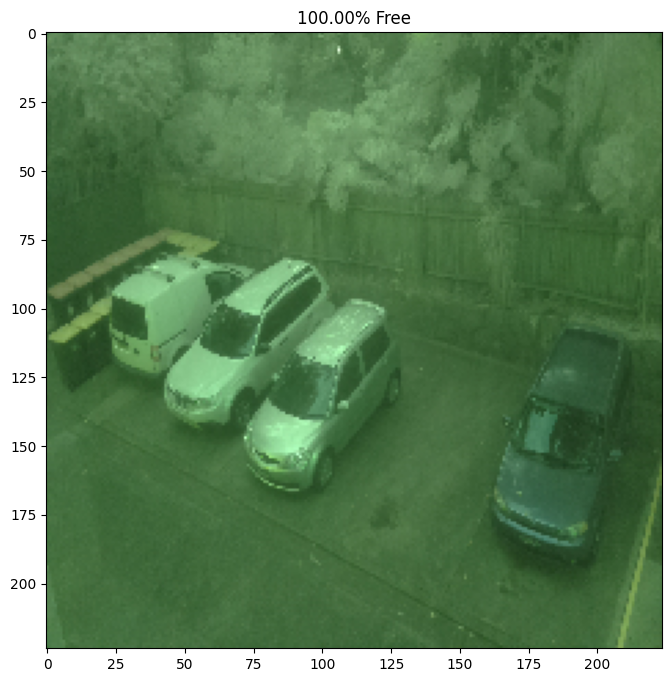

In [ ]:
# Normal Prediction
'''
Free/img_129173058.jpg
Free/img_723080007.jpg
Free/img_815061601.jpg
Full/img_127040601.jpg
Full/img_809172559.jpg
'''
test_img = img_to_array(load_img(os.path.join(BASE_PATH, 'Free/img_815061601.jpg'), target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


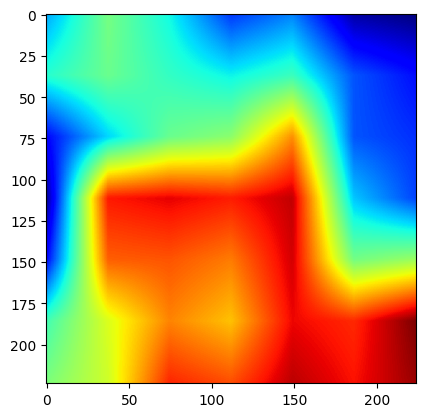

In [ ]:
# Draw Activation Map
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) GAP 전
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1) # GAP 생략

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

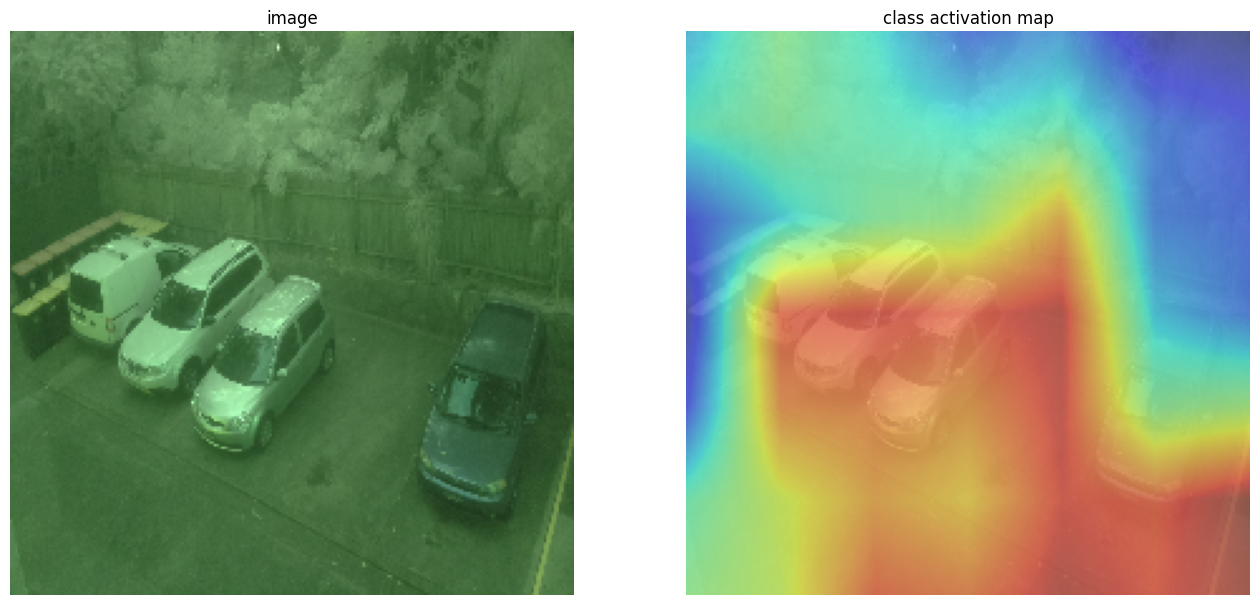

In [ ]:
# result
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)

ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()